In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!which python

/global/homes/x/xju/.conda/envs/py3.9/bin/python


In [3]:
import uproot
import awkward
import numpy as np

In [4]:
print(uproot.__version__)

5.0.6


You may have to update the syntax if you are using a different `uproot5` version.

In [5]:
filename = "/global/cfs/cdirs/m3443/data/TracklessBtagging/v1/Delphe_Hbb_5k_s1234.root"
tree_name = "Delphes"

In [ ]:
tree = uproot.open(filename)[tree_name]

## Print all branches in the TTree

### Branches of interest

We are interested in:

* "Jet" (jet object, which we will identify b-jets from), 
* "Track" (trajectories associated with a jet), 
* and "Tower" (energy deposits associated with a jet)



In [7]:
## tree.keys()

['Event',
 'Event/Event.fUniqueID',
 'Event/Event.fBits',
 'Event/Event.Number',
 'Event/Event.ReadTime',
 'Event/Event.ProcTime',
 'Event/Event.ProcessID',
 'Event/Event.MPI',
 'Event/Event.Weight',
 'Event/Event.CrossSection',
 'Event/Event.CrossSectionError',
 'Event/Event.Scale',
 'Event/Event.AlphaQED',
 'Event/Event.AlphaQCD',
 'Event/Event.ID1',
 'Event/Event.ID2',
 'Event/Event.X1',
 'Event/Event.X2',
 'Event/Event.ScalePDF',
 'Event/Event.PDF1',
 'Event/Event.PDF2',
 'Event_size',
 'Particle',
 'Particle/Particle.fUniqueID',
 'Particle/Particle.fBits',
 'Particle/Particle.PID',
 'Particle/Particle.Status',
 'Particle/Particle.IsPU',
 'Particle/Particle.M1',
 'Particle/Particle.M2',
 'Particle/Particle.D1',
 'Particle/Particle.D2',
 'Particle/Particle.Charge',
 'Particle/Particle.Mass',
 'Particle/Particle.E',
 'Particle/Particle.Px',
 'Particle/Particle.Py',
 'Particle/Particle.Pz',
 'Particle/Particle.P',
 'Particle/Particle.PT',
 'Particle/Particle.Eta',
 'Particle/Particle.

In [8]:
branches = ["Jet.PT", "Jet.Eta", "Jet.Phi", "Jet.Constituents", "Jet.Flavor", 
            "Tower.ET", "Tower.Eta", "Tower.Phi", "Tower.fUniqueID",
            "Track.PT", "Track.Eta", "Track.Phi", "Track.fUniqueID",
            "Particle.PT"
           ]

Loop over all events in the Root file. But only look at the first event!

In [27]:
for array in tree.iterate(branches, step_size=10):
    break

In [28]:
array[1]

<Record {'Jet.PT': [47.9, ...], ...} type='{"Jet.PT": var * float32, "Jet.E...'>

In [29]:
event = array[1]

### Jet properties

There are three jets in the event!

In [30]:
event["Jet.PT"], event["Jet.Eta"], event["Jet.Flavor"]

(<Array [47.9, 36.5] type='2 * float32'>,
 <Array [2.37, 4.12] type='2 * float32'>,
 <Array [5, 0] type='2 * uint32'>)

Jet flavor of `5` means it is a b-jet (our signal); otherwise, it is a background jet.

### Tracks and Towers

In [35]:
track_ids = event["Track.fUniqueID"]
print(track_ids)
print("# of Tracks in the event:", len(track_ids))

[1635, 1636, 1637, 1638, 1639, 1640, ..., 1668, 1669, 1670, 1671, 1672, 1673]
# of Tracks in the event: 39


In [37]:
tower_ids = event["Tower.fUniqueID"]
tower_et = event["Tower.ET"]
print(tower_ids)
print("# of Towers in the event:", len(tower_ids))

[1676, 1678, 1681, 1683, 1685, 1687, ..., 2199, 2201, 2203, 2205, 2207, 2209]
# of Towers in the event: 191


From these *tracks* and *towers*, we used an algorithm to reconstruct *three* jets in the event. So the jets should have connections to the tracks and towers.

### Particles

In [38]:
print("# of particles: ", len(event["Particle.PT"]))

# of particles:  1274


## Jet constituents

In this event, there are *two* jets. The first one is b-jet (signal) and the other is QCD jet (background)

In [40]:
event["Jet.Constituents"][0]

<Record {fName: '', fSize: 16, refs: [...]} type='TRefArray[fName: string, ...'>

In [44]:
event["Jet.Constituents"][0].fSize

16

Let's look at the first jet's contituents.

In [48]:
contituent = event["Jet.Constituents"][0]

In [49]:
contituent.refs.to_numpy()

array([2101, 2131, 2116, 2120, 2123, 2107, 2113, 1881, 1879, 1859, 1863,
       1876, 1865, 1869, 1874, 2110], dtype=int32)

In [53]:
print(event["Track.fUniqueID"])
print(event["Tower.fUniqueID"])

[1635, 1636, 1637, 1638, 1639, 1640, ..., 1668, 1669, 1670, 1671, 1672, 1673]
[1676, 1678, 1681, 1683, 1685, 1687, ..., 2199, 2201, 2203, 2205, 2207, 2209]


### Tracks and Towers associated with Jets

In [51]:
towers_in_jet = np.isin(tower_ids, contituent.refs.to_numpy())
tower_et_in_jet = tower_et[towers_in_jet]
tower_et_in_jet

<Array [1.29, 6.41, 1.3, 0.105, ..., 8.83, 3.75, 0.36] type='16 * float32'>

In [52]:
tracks_in_jet = np.isin(track_ids, contituent.refs.to_numpy())
np.sum(tracks_in_jet)

0

This means no tracks associated with jets. But it's not true. Let's plot the jet information

In [73]:
jet_idx = 0
jet_eta, jet_phi = event["Jet.Eta"][jet_idx], event["Jet.Phi"][jet_idx]

# tower eta and phi inside the jet
jet_tower_eta = event["Tower.Eta"][towers_in_jet]
jet_tower_phi = event["Tower.Phi"][towers_in_jet]


# track eta and phi *in the event*
track_eta = event["Track.Eta"]
track_phi = event["Track.Phi"]

In [56]:
import matplotlib.pyplot as plt

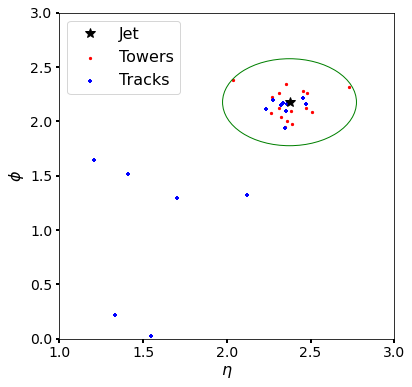

In [94]:
fontsize = 16
markersize = 20
fig, ax = plt.subplots(figsize=(6,6))

plt.plot([jet_eta], [jet_phi], "*", c='k', label="Jet")
plt.scatter(jet_tower_eta, jet_tower_phi, marker='.', s=markersize, c='r', label="Towers")
circle = plt.Circle((jet_eta, jet_phi), 0.4, color='g', fill=False)

plt.scatter(track_eta, track_phi, marker='+', s=markersize, c="b", label="Tracks")

ax.add_patch(circle)

ax.set_xlim(1, 3)
ax.set_ylim(0, 3)

ax.set_xlabel("$\eta$", fontsize=fontsize)
ax.set_ylabel("$\phi$", fontsize=fontsize)
plt.legend(frameon=True, fancybox=True, fontsize=fontsize)